### Final Propensity matching results

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [6]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [7]:
%config Completer.use_jedi = False

### Load pre matching data

In [8]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2.p ./Pre_Matching_DATA/treated2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controls.p ./Pre_Matching_DATA/controls.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [9]:
treated = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [10]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [11]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((26040, 91), 201710, 202107)

In [12]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 91), 201701, 202107)

In [13]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [15]:
# def get_treated_agg(treated, pmpm):
    
#     #get one year before dates
#     treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
#     treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
#     treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, month_offset=12)
    
#     treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
#     for i, (index, row) in tqdm(enumerate(treated.iterrows())):
#         pid = row.PERS_ID
#         myr = row.MYR
#         old_myr = row.MYR_12
#         history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
#         agg_data = history[col_seq_can_all].mean()
#         agg_data.PERS_ID = str(int(row.PERS_ID))
#         agg_data.MYR     = int(row.MYR)
#         treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
#     treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
#     treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
#     treated_aggregate = treated_aggregate.reset_index(drop=True)
    
#     return treated_aggregate
    

In [16]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./FinalData/treated_aggregated_filtered_final_g.p")

In [14]:
sorted_months = treated.MYR.sort_values().unique()

In [15]:
sorted_months

array([201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901,
       201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909,
       201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101,
       202102, 202103, 202104, 202105, 202106, 202107])

In [16]:
treated_aggregate = pd.read_pickle("./Final/Data/Common/treated_aggregated_filtered_final.p") #goes into matching as tr_agg

In [20]:
# controls_aggregate = data_process.get_average_final_record(controls.copy(), sorted_months, pmpm[col_seq_can_all].copy())
# controls_aggregate.to_pickle("./Final/Data/PCA/controls_aggregated_filtered_final.p")

In [17]:
controls_aggregate = pd.read_pickle("./Final/Data/Common/controls_aggregated_filtered_final.p")

In [18]:
treated_original = treated[treated.set_index(['PERS_ID','MYR']).index.isin(treated_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)
controls_original = controls[controls.set_index(['PERS_ID','MYR']).index.isin(controls_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [21]:
del treated, controls

In [24]:
# !aws s3 cp ./Final/Data/PCA/treated_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/treated_agg.p --acl bucket-owner-full-control
# !aws s3 cp ./Final/Data/PCA/controls_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/controls_agg.p --acl bucket-owner-full-control

# Load Model and Pick Columns for Matching

In [23]:
model = models.load_model(pp_str+"TF_Latent_Model_m6_Canary_stacked_logfixed", compile=False)

In [24]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [25]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR',  onset]
extra_cols = ['IP_BIN6', 'ER_BIN6','LOB']

In [33]:
treated_latent = data_process.transform_features_with_NN(model, treated_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
treated_latent1 = treated_original[cols_to_keep+extra_cols]
treated_latent = pd.concat([treated_latent1, treated_latent.loc[:,'x1':]], axis=1)

In [35]:
controls_latent = data_process.transform_features_with_NN(model, controls_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
controls_latent1 = controls_original[cols_to_keep+extra_cols]
controls_latent = pd.concat([controls_latent1, controls_latent.loc[:,'x1':]], axis=1)

In [37]:
del treated_latent1, controls_latent1

In [38]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [39]:
controls_latent.shape, controls_original.shape

# Matching

In [40]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated_latent.copy(), 
                                           controls_latent.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:274505 before they were:304151


0it [00:00, ?it/s]

IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None


1568it [26:42,  1.02s/it]

There were no matches for 0 out of 1568 patients
CPU times: user 37min 46s, sys: 25min 41s, total: 1h 3min 28s
Wall time: 26min 46s


In [41]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [42]:
matched_controls_5N = get_data(matched0)

### Result Folder Base

In [46]:
data_base = "./Final/Data/MHTM/"
result_base = "./Final/results/MHTM/"
Path(data_base).mkdir(exist_ok=True)
Path(result_base).mkdir(exist_ok=True)

In [47]:
matched_controls_5N.to_pickle(data_base+"matched_controls_5N.p")

In [48]:
matched_data0.to_pickle(data_base+"matched_controls_latent.p")

### Calculate matched controls agg and matched controls original 

In [49]:
matched_controls_original = controls_original[controls_original.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [50]:
matched_controls_original.to_pickle(data_base+"matched_controls_original.p")

In [51]:
matched_controls_aggregate = controls_aggregate[controls_aggregate.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [52]:
matched_controls_aggregate.to_pickle(data_base+"matched_controls_aggregate.p")

### List containing all numerical columns

In [53]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [54]:
# del controls, controls2

In [55]:
treated = pd.read_pickle(pp_str+'treated2.p')

In [56]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 29s, sys: 7.21 s, total: 2min 36s
Wall time: 2min 36s


In [57]:
conds_first

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.205736        50.458462  -0.717534  4.730631e-01          44.310976   47.606399
ALLOW_AMT        693.750000       699.309546  -0.062714  9.499960e-01        1065.926022  648.802692
MBR_GNDR           0.205736         0.211795  -0.539565  5.895105e-01           0.442749    0.431056
CC_TOBACCO         0.061097         0.092231  -4.021556  5.828570e-05           0.074202    0.098400
CC_PRESSURE        0.001247         0.004443  -1.868574  6.171448e-02           0.007390    0.006602
CC_OBESITY         0.456359         0.281136  13.877027  2.427881e-43           0.108841    0.228035
CC_HYPERTENSION    0.324813         0.242628   6.845779  8.102067e-12           0.207717    0.249365
CC_HYPOTHYROID     0.094763         0.079844   1.969787  4.889331e-02           0.047300    0.063484
CC_DX_CNT          2.706359         2.335129   6.101776  1.092109e-09           1.824419    2.343702
ACUTE2             0.038653         0.034738   0.729962  4.654321e-01           0.063258    0.051549
ACUTE6             0.111596         0.110139   0.132956  8.942310e-01           0.063258    0.153377
IP_BIN6            0.028055         0.026390   0.328115  7.428322e-01           0.020587    0.046851
ER_BIN6            0.088529         0.087653   0.091884  9.267921e-01           0.047286    0.116176
LOB                0.951995         0.951394   0.101676  9.190162e-01           0.755775    0.787836

In [61]:
conds_first.to_csv(result_base+"stats_matching/conds_original_first.csv", index=True, header=True)
full_first.to_csv(result_base+"stats_matching/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv(result_base+"stats_matching/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv(result_base+"stats_matching/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [62]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.65 s, sys: 16.6 ms, total: 2.67 s
Wall time: 2.67 s


In [63]:
conds_lat

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1  -12.528155       -12.321585 -0.328202  0.742766         -12.528155 -12.528155
x2  -26.217367       -25.792532 -0.328482  0.742555         -26.217367 -26.217367
x3   17.328354        17.040022  0.328638  0.742437          17.328354  17.328354
x4    0.044560         0.045586 -0.224673  0.822239           0.044560   0.044560
x5   44.281585        43.564166  0.330772  0.740824          44.281585  44.281585
x6   -1.723345        -1.694639 -0.332730  0.739346          -1.723345  -1.723345
x7   -0.408454        -0.400025 -0.315820  0.752147          -0.408454  -0.408454
x8   -0.827719        -0.818486 -0.254787  0.798893          -0.827719  -0.827719
x9   -0.639013        -0.627690 -0.261981  0.793342          -0.639013  -0.639013
x10  11.719368        11.533697  0.325041  0.745158          11.719368  11.719368
x11   0.385300         0.387013 -0.081233  0.935258           0.385300   0.385300
x12 -13.539235       -13.321437 -0.326412  0.744120         -13.539235 -13.539235
x13  -1.109277        -1.090737 -0.273658  0.784354          -1.109277  -1.109277
x14   1.580352         1.556611  0.279417  0.779931           1.580352   1.580352
x15   2.902335         2.849074  0.302440  0.762324           2.902335   2.902335
x16  20.643822        20.315540  0.324207  0.745788          20.643822  20.643822

In [64]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [65]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(matched_controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 3.36 s, sys: 57 ms, total: 3.42 s
Wall time: 3.42 s


In [66]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                    mean             mean  t-stat   pval
AGE_AT_MIDMONTH   49.948           49.994  -0.131  0.896
ALLOW_AMT        781.696          737.974   0.782  0.434
MBR_GNDR           0.205            0.212  -0.568  0.570
CC_TOBACCO         0.055            0.089  -4.648  0.000
CC_PRESSURE        0.001            0.004  -1.707  0.088
CC_OBESITY         0.419            0.256  14.099  0.000
CC_HYPERTENSION    0.314            0.234   7.234  0.000
CC_HYPOTHYROID     0.088            0.077   1.632  0.103
CC_DX_CNT          2.537            2.214   5.582  0.000
LOB                0.953            0.947   0.986  0.324

In [67]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [68]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 29.6 s, sys: 2.51 s, total: 32.1 s
Wall time: 32.1 s


In [69]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.420  -6.732  0.000             50.379   50.236
ALLOW_AMT        782.435          794.643  -0.459  0.646            857.856  706.609
MBR_GNDR           0.189            0.199  -3.581  0.000              0.433    0.429
CC_TOBACCO         0.063            0.093 -15.243  0.000              0.102    0.100
CC_PRESSURE        0.002            0.004  -4.726  0.000              0.013    0.008
CC_OBESITY         0.505            0.325  54.701  0.000              0.255    0.286
CC_HYPERTENSION    0.325            0.267  18.935  0.000              0.329    0.300
CC_HYPOTHYROID     0.095            0.090   2.344  0.019              0.078    0.075
CC_DX_CNT          2.918            2.621  18.629  0.000              2.955    2.759
ACUTE2             0.032            0.036  -2.637  0.008              0.060    0.050
ACUTE6             0.100            0.108  -3.187  0.001              0.168    0.150
IP_BIN6            0.025            0.032  -5.170  0.000              0.055    0.049
ER_BIN6            0.079            0.081  -1.015  0.310              0.122    0.111
LOB                0.953            0.948   3.494  0.000              0.802    0.803

In [70]:
conds.to_csv(result_base+"stats_matching/conds_original.csv", index=True, header=True)
full.to_csv(result_base+"stats_matching/full_original.csv", index=True, header=True)
conds_AllCols.to_csv(result_base+"stats_matching/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv(result_base+"stats_matching/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [71]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = matched_data0[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)


CPU times: user 169 ms, sys: 0 ns, total: 169 ms
Wall time: 169 ms


In [72]:
treated_latent[latent_cols].mean()*(10**14)

x1    -1.293223e+15
x2    -2.703271e+15
x3     1.788599e+15
x4     4.967780e+12
x5     4.563819e+15
x6    -1.789661e+14
x7    -4.275242e+13
x8    -8.609601e+13
x9    -6.755733e+13
x10    1.208765e+15
x11    4.092208e+13
x12   -1.396679e+15
x13   -1.162607e+14
x14    1.644855e+14
x15    3.024603e+14
x16    2.128516e+15
dtype: float64

In [73]:
full_latA

Treated                   Matched Controls                       Test-TC                General Population                   Test-TG          Random                   Test-TR     
          mean        std  count             mean        std   count     t-stat           pval               mean        std  count  t-stat pval       mean        std  count  t-stat pval
x1  -12.932242  23.435740  24495       -13.488880  27.521015  106342   2.930253   3.387444e-03         -12.932242  23.435740  24495     0.0  1.0 -12.932242  23.435740  24495     0.0  1.0
x2  -27.032675  48.129627  24495       -28.289303  56.516850  106342   3.221238   1.276692e-03         -27.032675  48.129627  24495     0.0  1.0 -27.032675  48.129627  24495     0.0  1.0
x3   17.885962  32.665661  24495        18.700710  38.351906  106342  -3.077661   2.086752e-03          17.885962  32.665661  24495     0.0  1.0  17.885962  32.665661  24495     0.0  1.0
x4    0.049678   0.147366  24495         0.014414   0.219476  106342  23.934632  2.501775e-126           0.049678   0.147366  24495     0.0  1.0   0.049678   0.147366  24495     0.0  1.0
x5   45.638458  80.693008  24495        47.816868  94.749268  106342  -3.330842   8.660762e-04          45.638458  80.693008  24495     0.0  1.0  45.638458  80.693008  24495     0.0  1.0
x6   -1.789664   3.197649  24495        -1.789890   3.798396  106342   0.008626   9.931178e-01          -1.789664   3.197649  24495     0.0  1.0  -1.789664   3.197649  24495     0.0  1.0
x7   -0.427524   0.990194  24495        -0.438509   1.169523  106342   1.361849   1.732480e-01          -0.427524   0.990194  24495     0.0  1.0  -0.427524   0.990194  24495     0.0  1.0
x8   -0.860960   1.334012  24495        -0.821911   1.614609  106342  -3.518622   4.339407e-04          -0.860960   1.334012  24495     0.0  1.0  -0.860960   1.334012  24495     0.0  1.0
x9   -0.675570   1.608162  24495        -0.649337   1.917817  106342  -1.986059   4.702885e-02          -0.675570   1.608162  24495     0.0  1.0  -0.675570   1.608162  24495     0.0  1.0
x10  12.087600  21.257837  24495        12.588666  24.977961  106342  -2.906505   3.655518e-03          12.087600  21.257837  24495     0.0  1.0  12.087600  21.257837  24495     0.0  1.0
x11   0.409220   0.767136  24495         0.346218   0.968507  106342   9.516604   1.818184e-21           0.409220   0.767136  24495     0.0  1.0   0.409220   0.767136  24495     0.0  1.0
x12 -13.966744  24.855131  24495       -14.560392  29.180155  106342   2.947284   3.206353e-03         -13.966744  24.855131  24495     0.0  1.0 -13.966744  24.855131  24495     0.0  1.0
x13  -1.162604   2.521295  24495        -1.154018   2.988867  106342  -0.416740   6.768692e-01          -1.162604   2.521295  24495     0.0  1.0  -1.162604   2.521295  24495     0.0  1.0
x14   1.644851   3.173514  24495         1.647038   3.745042  106342  -0.084677   9.325182e-01           1.644851   3.173514  24495     0.0  1.0   1.644851   3.173514  24495     0.0  1.0
x15   3.024595   6.573370  24495         3.114505   7.728571  106342  -1.685703   9.185547e-02           3.024595   6.573370  24495     0.0  1.0   3.024595   6.573370  24495     0.0  1.0
x16  21.285192  37.680370  24495        22.253460  44.249672  106342  -3.170177   1.523812e-03          21.285192  37.680370  24495     0.0  1.0  21.285192  37.680370  24495     0.0  1.0

In [74]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [75]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = matched_controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 708 ms, sys: 0 ns, total: 708 ms
Wall time: 708 ms


In [76]:
conds_aggA

Treated Matched Controls    Test-TC                General Population      Random
                       mean             mean     t-stat           pval               mean        mean
AGE_AT_MIDMONTH   50.580075        50.932676  -3.981215   6.860086e-05          49.947968   49.947968
ALLOW_AMT        808.023126       800.036496   0.559493   5.758260e-01         781.696414  781.696414
MBR_GNDR           0.191590         0.199246  -2.711969   6.689364e-03           0.205357    0.205357
CC_TOBACCO         0.062304         0.092118 -15.689918   1.992061e-55           0.055015    0.055015
CC_PRESSURE        0.001699         0.004065  -6.013523   1.820136e-09           0.001226    0.001226
CC_OBESITY         0.496366         0.308810  60.316023   0.000000e+00           0.418996    0.418996
CC_HYPERTENSION    0.326315         0.259937  22.982727  1.183265e-116           0.313737    0.313737
CC_HYPOTHYROID     0.092917         0.088136   2.584579   9.750863e-03           0.087809    0.087809
CC_DX_CNT          2.828596         2.507703  21.025927   5.523686e-98           2.536723    2.536723
LOB                0.955921         0.948716   4.754959   1.986977e-06           0.953023    0.953023

In [77]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [78]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [79]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [80]:
base_path =  result_base
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [81]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [82]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [83]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [84]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [130]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

In [131]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [132]:
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, columns_to_match, return_array = True)

In [133]:
controls_original.shape, matched_controls_original.shape

In [134]:
un_controls_ = controls_original[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [135]:
un_controls_all = controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T

In [136]:
un_controls_all.to_csv(result_base+"stats_matching/unmatched_all_cols_stats.csv", index=True, header=True)

In [137]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls_original))/(len(treated)+len(controls_original))

In [138]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

In [139]:
stdMeans

Treated  Controls  MControls
AGE_AT_MIDMONTH  2.608468  2.686381   2.621598
ALLOW_AMT        0.148225  0.187066   0.149413
MBR_GNDR         0.415457  0.875053   0.427692
CC_TOBACCO       0.197653  0.346797   0.298373
CC_PRESSURE      0.010585  0.120098   0.037720
CC_OBESITY       1.006217  0.637581   0.619872
CC_HYPERTENSION  0.679138  0.740844   0.507301
CC_HYPOTHYROID   0.339865  0.304591   0.286357
CC_DX_CNT        0.909817  1.077759   0.785018
ACUTE2           0.152936  0.227996   0.137445
ACUTE6           0.213735  0.335652   0.210943
IP_BIN6          0.095697  0.199877   0.090018
ER_BIN6          0.204459  0.292982   0.202437
LOB              2.433451  2.071915   2.431913

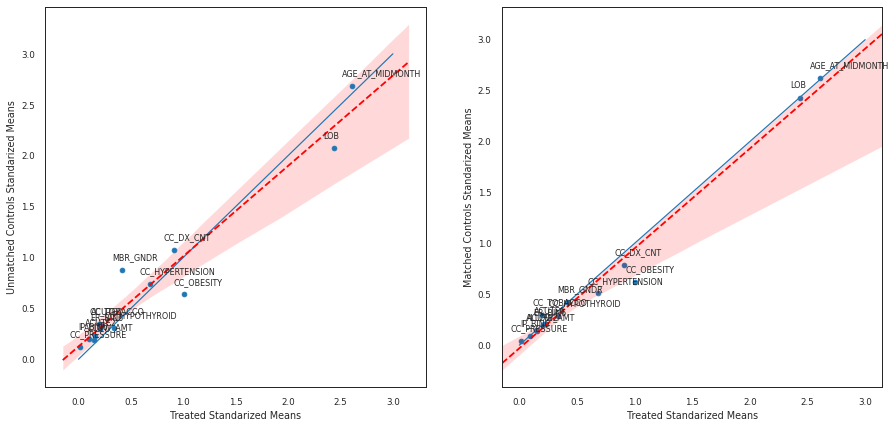

In [140]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig(result_base+"figures/std_means_graph.png")
fig.show()

# Ratio Stats

In [95]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [96]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [97]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [98]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, controls_original[[col]].values)
        d_metric_before.loc[0,col] = d

In [145]:
d_metric_before.

0
CC_HEPATITIS_B_ACUTE        0.002869
CC_LEUKEMIAS                0.004021
CC_HEPATITIS_E              0.004032
CC_FIBROMYALGIA             0.005191
CC_PERSONALITY              0.005469
CC_HEPATITIS_D              0.005502
ER_C                        0.006985
CC_SPINA_BIFIDA             0.007018
ALLOW_ER                    0.007147
CC_TRAUMATIC_BRAIN          0.010869
CC_ENDOMETRIAL_CANCER       0.011875
CC_HEPATITIS_A              0.013848
CC_CEREBRAL_PALSY           0.015940
ACUTE_C                     0.017054
ALLOW_AMT                   0.017102
CC_ADHD                     0.018774
CC_HEPATITIS_B_CHRONIC      0.019984
ALLOW_IP                    0.021577
CC_HEPATITIS_C_ACUTE        0.023830
CC_ARTHRITIS                0.025743
CC_PTSD                     0.026201
CC_MUSCULAR_DYSTROPHY       0.029496
CC_CYSTIC_FIBROSIS          0.029590
CC_LIVER                    0.031985
CC_BIPOLAR                  0.034489
PREGNANCY                   0.034817
AGE_AT_MIDMONTH             0.038863
CC_CATARACT                 0.043088
CC_HYPOTHYROID              0.043779
CC_VISUAL_IMPAIR            0.046064
CC_ANEMIA                   0.046514
CC_HEPATITIS_C_UNSPECIFIED  0.046573
CC_LUNG_CANCER              0.048055
CC_SPINAL_CORD              0.049092
CC_COLORECTAL_CANCER        0.049306
CC_DEVELOP_DELAYS           0.050590
CC_HYPERTENSION             0.050973
CC_HEARING_IMPAIR           0.051957
CC_AMI                      0.053294
CC_LEARN_DISAB              0.053973
CC_EPILEPSY                 0.058982
CC_HIP_FRACTURE             0.059537
CC_DEPRESSION               0.061509
CC_MULTIPLE_SCLEROSIS       0.061581
CC_MOBILITY_IMPAIR          0.061977
CC_DEPRESSIVE_DISORDERS     0.062788
CC_GLAUCOMA                 0.065073
CC_HEPATITIS_C_CHRONIC      0.065898
CC_STROKE                   0.066658
ER_BIN                      0.066718
IP_BIN                      0.068095
CC_INT_DISAB                0.068314
CC_HEPATITIS_GEN            0.071051
IP_C                        0.075701
CC_BREAST_CANCER            0.076516
CC_DX_CNT                   0.080205
CC_SCHIZOPHRENIA            0.080329
CC_OSTEOPOROSIS             0.084021
CC_ASTHMA                   0.084555
ER_BIN2                     0.084982
ACUTE                       0.088808
IP_BIN2                     0.090354
CC_AUTISM                   0.096304
CC_HYPERLIPIDEMIA           0.097063
CC_PROSTATE_CANCER          0.099813
CC_ANXIETY_DISORDER         0.105468
ACUTE2                      0.113792
CC_SCHIZOPHRENIA_OTHER      0.115778
ER_BIN6                     0.117808
CC_DISAB_DX_CNT             0.121306
CC_ALZHEIMER                0.121471
CC_PRESSURE                 0.129215
CC_HEART_FAILURE            0.133201
IP_BIN6                     0.137033
CC_COPD                     0.138520
CC_ATRIAL_FIB               0.145405
CC_BPH                      0.145498
CC_TOBACCO                  0.154327
ACUTE6                      0.159500
CC_ISCHEMIC                 0.172573
CC_MIGRAINE                 0.180443
CC_PERIPHERAL               0.192597
CC_ALZHEIMER_PLUS           0.202374
CC_CHRONIC_KIDNEY           0.272186
CC_DIABETES                 0.397714
LOB                         0.460482
CC_OBESITY                  0.486435
MBR_GNDR                    0.540250

In [100]:
d_metric_before.T.to_csv(result_base+"stats_matching/d_metric_before.csv", header=True, index=True)

In [101]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

65

In [102]:
d1 = d_metric_before.loc[:,:'LOB']

In [103]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0   0.54025         0.038863   0.017102  0.007147  0.021577  0.018774      0.121471           0.202374  0.053294   0.046514             0.105468      0.025743   0.084555       0.145405   0.096304    0.034489  0.145498          0.076516     0.043088            0.01594           0.272186              0.049306  0.13852             0.02959       0.061509                 0.062788            0.05059     0.397714         0.121306   0.080205               0.011875     0.058982         0.005191     0.065073           0.051957          0.133201        0.013848              0.002869                0.019984               0.02383                0.065898                    0.046573        0.005502        0.004032          0.071051         0.059537           0.097063         0.050973        0.043779      0.068314     0.172573        0.053973      0.004021  0.031985        0.048055     0.180443            0.061977               0.061581               0.029496    0.486435         0.084021   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.192597        0.005469     0.129215            0.099813  0.026201          0.080329                0.115778        0.049092         0.007018   0.066658    0.154327            0.010869          0.046064  0.460482

In [104]:
d1.T[d1.T[0]<0.1].size

56

In [105]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        d_metric_after.loc[0,col] = d

In [106]:
d_metric_after.T.to_csv(result_base+"stats_matching/d_metric_after.csv", header=True, index=True)

In [107]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

79

In [108]:
d2 = d_metric_after.loc[:,:'LOB']

In [109]:
d2.T[d2.T[0]<0.1].size

66

In [110]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.035774         0.711357   0.094767  0.859926  0.176039  3.743793      0.502838           0.447184  0.131135   0.080637             0.102981      0.810123   0.810839       0.028396   0.496058    0.154824  0.147961          0.454516      0.67041           0.195222           0.096187              0.461304  0.155755            0.961865       0.723158                 0.014775           0.491468     0.444073         0.248834   2.014389               2.442085     0.515048         7.100521     0.024897           0.358288          0.158204             NaN              5.376125                1.121494                   NaN                0.438513                    0.187014             NaN             NaN          0.396754         0.554888           0.786053         2.724618        0.556962      0.617693     0.012489        0.255581       9.42289  0.935886        0.381173     0.443619            0.364503               0.136202               0.705208    0.832984         0.835482   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR     LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2   ACUTE2  
0       0.019942        0.228782      0.25316            0.259642  0.719126          0.440391                0.449054         0.62386         0.501352   0.124123     0.69784            1.177101          0.525106  0.0729   0.639248  0.286886  0.102714  0.165414  0.020928  0.468844  0.117698  0.249573  0.042619  0.120596  0.283266  0.080538  0.15194

In [111]:
ratio.T[ratio.T[0]>=1.0].size

9

In [112]:
ratio.T.to_csv(result_base+"stats_matching/ratio.csv", header=True, index=True)

In [113]:
!aws s3 cp ../Final/Data/MHTM s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM --recursive --acl bucket-owner-full-control


The user-provided path ../Final/Data/MHTM does not exist.
